In [194]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
category_dict = {}
category_dict["Informatique"] = ["Tablette", "Ordinateur", "Portable"]
category_dict["Film"] = ["DVD", "TV", "Cinéma"]

In [ ]:
def generate_random_category(i, j):
    for

In [4]:
def count(y):
    return sum([len(y.get(x, 0)) for x in y])

In [228]:
class Clients:
    def __init__(self, n_client, category_dict, desire_threshold=2):
        self.category_dict = category_dict
        self.category_list = list(category_dict.keys())
        self.n_client = n_client
        self.n_category = len(category_dict.keys())
        self.n_commodity = count(category_dict)
        self.desire_threshold_list = [desire_threshold] * n_client
        self.preference_matrix = np.zeros((n_client, self.n_commodity))
        self.desire_matrix = np.zeros((n_client, self.n_commodity))
        
        self.reward_history = []
        self.regret_history = []
        
        self.generate_client_distribution()
        
    def generate_client_distribution(self):
        proba_category = np.random.uniform(0, 0.9, (self.n_client, self.n_category))
        proba_commodity_list = []
        for j in range(proba_category.shape[1]):
            #print('---aaa---', np.expand_dims(proba_category[:,j],1).shape)
            proba_commodity_list.append(np.repeat(np.expand_dims(proba_category[:,j],1), len(self.category_dict[self.category_list[j]]), axis=1))
        self.preference_matrix = np.hstack(proba_commodity_list)
        #print(proba_commodity_list[0].shape)
        #print(proba_commodity_list[1].shape)
        #print(self.proba_commodity.shape)
        self.preference_matrix += np.random.uniform(0, 0.1, (self.n_client, self.n_commodity))
        return
    
    def get_clients(self, n):
        return np.random.choice(list(range(self.n_client)), n, replace=False)
    
    def update_desire(self, clients_list, rate_rise=None, rate_decay=0.01):
        if rate_decay is not None:
            self.desire_matrix *= 1 - rate_decay
        
        if rate_rise is None:
            rate_rise = np.mean(desire_threshold) * 0.5
        if rate_rise < 0:
            rate_rise = 0
        self.desire_matrix[clients_list] += rate_rise * self.preference_matrix[clients_list]
    
    def get_waiting_list(self, client):
        client_desire = self.desire_matrix[client]
        return np.where(client_desire>self.desire_threshold_list[client])[0]
    
    def return_command(self, client, recommandation_list):
        client_waiting_list = self.get_waiting_list(client)
        command_list = np.array([x for x in recommandation_list if x in client_waiting_list])
        for c in command_list:
            self.desire_matrix[client][c] = 0
        return command_list
    
    def get_reward(self, client, recommandation_list):
        articles_bought = self.return_command(client, recommandation_list)
        self.reward_history.append(len(articles_bought))
        return len(articles_bought)

    def get_regret(self, client, recommandation_list):
        #articles_bought = self.return_command(client, recommandation)
        articles_wanted_to_buy = self.get_waiting_list(client)
        regret = min(len(articles_wanted_to_buy), len(recommandation_list)) - self.get_reward(client, recommandation_list)
        self.regret_history.append(regret)
        return regret

In [226]:
np.where(np.array([1,2,3,4,5])<4)[0]

array([0, 1, 2])

In [232]:
def run(n):
    C = Clients(n_client=10, category_dict=category_dict)
    for _ in range(n):
        active_clients = C.get_clients(5)
        C.update_desire(active_clients, rate_rise=0.5)
        for c in active_clients:
            C.get_regret(c, np.random.choice([1,2,3,4,5,6], 2, replace=False))
    return C

In [233]:
C = run(100)

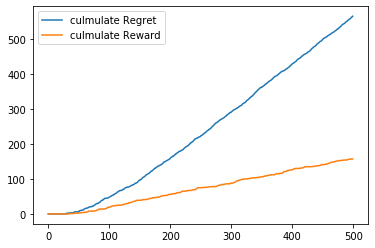

In [234]:
plt.plot(np.cumsum(C.regret_history))
plt.plot(np.cumsum(C.reward_history))
plt.legend(["culmulate Regret", "culmulate Reward"])

In [127]:
np.random.choice([1,2,3], 2, replace=False)

array([2, 1])

In [123]:
C.update_desire(C.get_clients(1), rate_rise=0.5)

In [124]:
C.desire_matrix

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.42446944, 0.38809191, 0.40641486, 0.35376478, 0.34405558,
        0.33749734]])

In [95]:
C.get_waiting_list(0)

array([], dtype=float64)

In [85]:
np.array([[1], [1,2]])

array([list([1]), list([1, 2])], dtype=object)